In [1]:
import os

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
# Get the list of available GPUs
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# Print the list of available GPUs
print("Available GPUs:", gpu_devices)

# Check if TensorFlow is using GPU
if gpu_devices:
    print("TensorFlow is using GPU.")
    # Specify which GPU to use (assuming you have at least one GPU)
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
else:
    print("TensorFlow is NOT using GPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras import models, layers

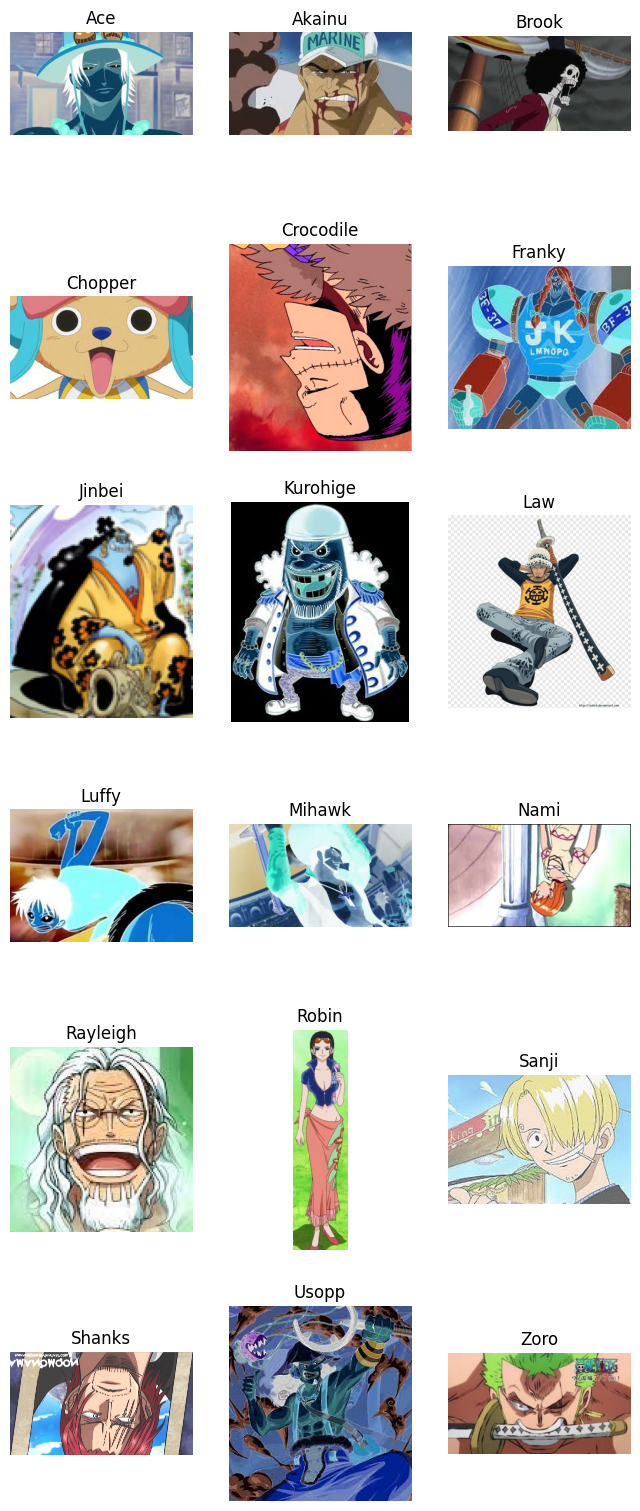

In [4]:
# main directory
main_dir = "./Data_2/"

# list directory of character
char_dir = [char for char in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, char))]

# set figure and axis
fig, ax = plt.subplots(6, 3, figsize=(8, 20))

for char, ax in zip(char_dir, ax.flatten()):
    # join directory
    image_list = os.listdir(os.path.join(main_dir, char))
    
    # choose one image randomly
    image = image_list[np.random.randint(0, len(image_list))]
    
    # join directory
    image_path = os.path.join(main_dir, char, image)
    
    # open
    pict = Image.open(image_path)
    
    # visualize
    ax.imshow(pict)
    ax.set_title(char)
    ax.axis("off")
    
# plt.show()

In [5]:
# How many image each char

for i, c in enumerate([os.path.join(main_dir, char) for char in char_dir]):
    print(f"Number files of {char_dir[i]} : {len(os.listdir(c))}")

Number files of Ace : 648
Number files of Akainu : 651
Number files of Brook : 657
Number files of Chopper : 648
Number files of Crocodile : 651
Number files of Franky : 651
Number files of Jinbei : 651
Number files of Kurohige : 648
Number files of Law : 651
Number files of Luffy : 654
Number files of Mihawk : 651
Number files of Nami : 665
Number files of Rayleigh : 651
Number files of Robin : 651
Number files of Sanji : 651
Number files of Shanks : 651
Number files of Usopp : 648
Number files of Zoro : 659


In [6]:
# params
width, height = (299, 299)
batch_size = 128

In [7]:
# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

train_datagen.shuffle=True

In [8]:
directory = "./Data_2/"

train_generator = train_datagen.flow_from_directory(
    directory,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"
)

val_generator = train_datagen.flow_from_directory(
    directory,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

Found 9396 images belonging to 18 classes.
Found 2341 images belonging to 18 classes.


In [9]:
pre_trained_model = InceptionV3(
    include_top=True,
    weights="imagenet",
    input_shape=(width, height, 3)
)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [10]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [11]:
layer = []

for i, nama in enumerate(pre_trained_model.layers):
    layer.append((i, nama.name))
    
layer

[(0, 'input_1'),
 (1, 'conv2d'),
 (2, 'batch_normalization'),
 (3, 'activation'),
 (4, 'conv2d_1'),
 (5, 'batch_normalization_1'),
 (6, 'activation_1'),
 (7, 'conv2d_2'),
 (8, 'batch_normalization_2'),
 (9, 'activation_2'),
 (10, 'max_pooling2d'),
 (11, 'conv2d_3'),
 (12, 'batch_normalization_3'),
 (13, 'activation_3'),
 (14, 'conv2d_4'),
 (15, 'batch_normalization_4'),
 (16, 'activation_4'),
 (17, 'max_pooling2d_1'),
 (18, 'conv2d_8'),
 (19, 'batch_normalization_8'),
 (20, 'activation_8'),
 (21, 'conv2d_6'),
 (22, 'conv2d_9'),
 (23, 'batch_normalization_6'),
 (24, 'batch_normalization_9'),
 (25, 'activation_6'),
 (26, 'activation_9'),
 (27, 'average_pooling2d'),
 (28, 'conv2d_5'),
 (29, 'conv2d_7'),
 (30, 'conv2d_10'),
 (31, 'conv2d_11'),
 (32, 'batch_normalization_5'),
 (33, 'batch_normalization_7'),
 (34, 'batch_normalization_10'),
 (35, 'batch_normalization_11'),
 (36, 'activation_5'),
 (37, 'activation_7'),
 (38, 'activation_10'),
 (39, 'activation_11'),
 (40, 'mixed0'),
 (41, 'co

In [12]:
# get mobilenetv2 partial model
last_layer = pre_trained_model.get_layer("mixed9")
partial_inception = models.Model(pre_trained_model.input, last_layer.output)

# define sequential model
model = models.Sequential([
    partial_inception,
    layers.Conv2D(64, (3, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(18, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 2048)        15722720  
                                                                 
 conv2d_94 (Conv2D)          (None, 6, 6, 64)          1179712   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1024)              590848    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                        

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [14]:
# use callback to early stopping

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80 and logs.get("val_accuracy")>0.80):
            print("\nAkurasi telah mencapai > 80%!")
            self.model.stop_training = True
            
early_stop = myCallback()

In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks = [early_stop]
)

Epoch 1/50
74/74 [==============================] - 442s 6s/step - loss: 2.6508 - accuracy: 0.1748 - val_loss: 2.2211 - val_accuracy: 0.3349
Epoch 2/50
74/74 [==============================] - 390s 5s/step - loss: 1.9809 - accuracy: 0.3931 - val_loss: 1.7404 - val_accuracy: 0.4677
Epoch 3/50
74/74 [==============================] - 397s 5s/step - loss: 1.5713 - accuracy: 0.5192 - val_loss: 1.4981 - val_accuracy: 0.5374
Epoch 4/50
74/74 [==============================] - 387s 5s/step - loss: 1.3096 - accuracy: 0.5936 - val_loss: 1.3944 - val_accuracy: 0.5660
Epoch 5/50
74/74 [==============================] - 479s 6s/step - loss: 1.1355 - accuracy: 0.6544 - val_loss: 1.2903 - val_accuracy: 0.6066
Epoch 6/50
74/74 [==============================] - 401s 5s/step - loss: 1.0274 - accuracy: 0.6885 - val_loss: 1.1916 - val_accuracy: 0.6352
Epoch 7/50
74/74 [==============================] - 283s 4s/step - loss: 0.8922 - accuracy: 0.7251 - val_loss: 1.2370 - val_accuracy: 0.6245
Epoch 8/50
74

In [18]:
history_2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks = [early_stop]
)

Epoch 1/10
74/74 [==============================] - 440s 6s/step - loss: 0.1777 - accuracy: 0.9419 - val_loss: 0.8760 - val_accuracy: 0.7749
Epoch 2/10
74/74 [==============================] - 437s 6s/step - loss: 0.1847 - accuracy: 0.9402 - val_loss: 0.8894 - val_accuracy: 0.7706
Epoch 3/10
74/74 [==============================] - 345s 5s/step - loss: 0.1801 - accuracy: 0.9428 - val_loss: 0.9109 - val_accuracy: 0.7766
Epoch 4/10
74/74 [==============================] - 312s 4s/step - loss: 0.1727 - accuracy: 0.9431 - val_loss: 0.8885 - val_accuracy: 0.7817
Epoch 5/10
74/74 [==============================] - 310s 4s/step - loss: 0.1632 - accuracy: 0.9473 - val_loss: 0.9567 - val_accuracy: 0.7732
Epoch 6/10
74/74 [==============================] - 309s 4s/step - loss: 0.1660 - accuracy: 0.9467 - val_loss: 0.9398 - val_accuracy: 0.7642
Epoch 7/10
74/74 [==============================] - 313s 4s/step - loss: 0.1706 - accuracy: 0.9460 - val_loss: 0.9071 - val_accuracy: 0.7792
Epoch 8/10
74

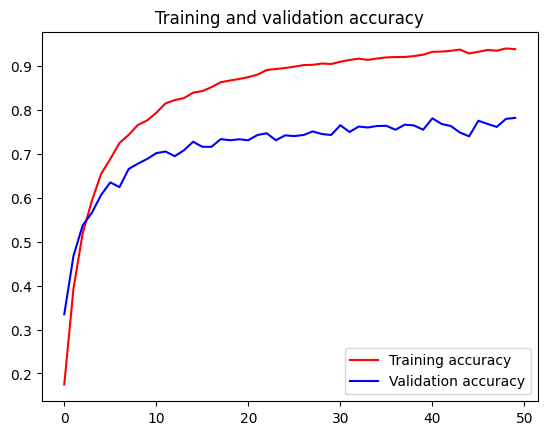

<Figure size 640x480 with 0 Axes>

In [16]:
# Evaluate model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [17]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = './saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


72558412